# 시작하기 전에
LSTM과 GRU는 순환 신경망에서 뺴놓을 수 없는 핵심으로써  
이전에 배운 것들보다 훨씬 복잡하다.  
하지만 높은 성능을 가지기 때문에 널리 사용된다.  


# LSTM 구조
Long Short Term Momory의 약자로 단기 기억을 오래 기억하기 위한 것이다.  
LSTM은 구조가 복잡하므로 단계적으로 설명하는 것이 좋다.  
하지만 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는건  
비슷하며 이런 구조를 여러개 가지고 있다.  
하나하나 따라가 보자  

1. 은닉상태 만들기  
은닉상태는 입력과 이전 타임스탭의 은닉상태 * 가중치, 활성화함수를  
통과시켜서 다음 은닉 상태를 만든다.  
활성화 함수는 시그모이드 함수를 사용한다.  
또 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 완성한다.  

2. 셀상태  
은닉 상태와 달리 셀 상태는 다음 층으로 전달되지 않고 LSTM셀에서 순환만 한다.  
셀 상태 계산법은 다음과 같다.  
입력과 은닉상태를 또 다른 가중치에 곱한다음 시그모이드 함수를 통과한다.  
그 다음 이전 타임 스텝의 셀 상태와 곱하여 새로운 셀 상태를 만든다.  
이 셀 상태가 오른쪽에서 tanh 함수를 통과하여 새로운 은닉상태를 만드는데 기여한다.  

---

복잡하다.  
LSTM은 마치 작은 셀을 여러 개 포함하고 있는 큰 셀처럼 보인다.  
중요한 것은 입력과 은닉상태에 곱해지는 가중치가 서로 다르다는 것이다.  
아직 끝나지 않았다.  

---

3. 여기에 2개의 작은 셀이 더 추가되어 셀 상태를 만드는데 기여한다.  
즉 LSTM에는 총 4개의 셀이 있다.  
이전처럼 입력과 은닉을 각기 다른 가중치에 곱하고 하나는 시그모이드  
다른 하나는 tanh 함수를 통과한다.  
이후 그 두 결과를 곱한 후 이전 셀 상태와 더한다.  
이 결과가 최정족인 다음 셀 상태가 된다.  

---

물론 이걸 직접할 필요는 없다.  
케라스에는 이미 LSTM 클래스가 준비되어 있다.  
이걸 사용해보자

# LSTM 신경망 훈련하기

In [1]:
# 데이터 불러오고 훈련세트와 검증세트로 분할
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 [==============================] - 0s 0us/step


이제 각 샘플의 길이를 100에 맞추고 부족하면 패딩을 추가한다.  

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen= 100)
val_seq = pad_sequences(val_input, maxlen= 100)

이제 LSTM을 사용한 순환층을 만든다.

In [3]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

모델의 구조를 출력해보자

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


전에 했던 SimpleRNN 모델의 파라미터는 200개 였다.  
그러나 LSTM에선 작은 셀이 4개 있으므로 4배가 늘어 800개가 되었다.  
모델을 컴파일 하고 훈련해보자  
이전과 마찬가지로 배치 크기는 64개, 에포크 횟수는 100이다.  
체크포인트와 조기종료 또한 동일하다.

In [5]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer = rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights= True)
history = model.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 19s 51ms/step - loss: 0.6922 - accuracy: 0.5336 - val_loss: 0.6911 - val_accuracy: 0.5646
Epoch 2/100
313/313 [==============================] - 16s 51ms/step - loss: 0.6879 - accuracy: 0.6115 - val_loss: 0.6833 - val_accuracy: 0.6628
Epoch 3/100
313/313 [==============================] - 27s 86ms/step - loss: 0.6608 - accuracy: 0.6874 - val_loss: 0.6279 - val_accuracy: 0.6936
Epoch 4/100
313/313 [==============================] - 21s 67ms/step - loss: 0.6069 - accuracy: 0.6944 - val_loss: 0.5962 - val_accuracy: 0.7038
Epoch 5/100
313/313 [==============================] - 14s 44ms/step - loss: 0.5753 - accuracy: 0.7272 - val_loss: 0.5683 - val_accuracy: 0.7264
Epoch 6/100
313/313 [==============================] - 13s 41ms/step - loss: 0.5495 - accuracy: 0.7474 - val_loss: 0.5444 - val_accuracy: 0.7480
Epoch 7/100
313/313 [==============================] - 13s 41ms/step - loss: 0.5281 - accuracy: 0.7646 - val_loss: 0.5255 - val_ac

훈련 손실과 검증 손실 그래프를 그려보자

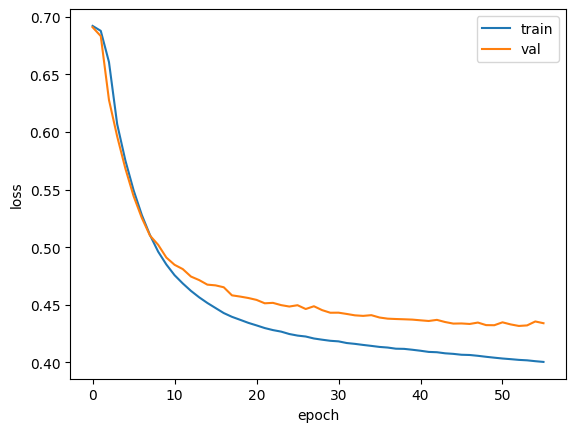

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련을 잘 수행했다.  
다만 과대적합을 더 강하게 제어할 수 없을까?  
드롭아웃을 적용시켜보자.  

# 순환층에 드롭아웃 적용하기
순환층은 자체적으로 드롭아웃 기능을 제공한다.  
전체적인 모델 구조는 이전과 같다.

In [7]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length = 100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

이 모델을 이전과 같은 조건으로 훈련해보자

In [8]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights= True)
history = model2.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 16s 45ms/step - loss: 0.6927 - accuracy: 0.5214 - val_loss: 0.6919 - val_accuracy: 0.5620
Epoch 2/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6908 - accuracy: 0.5789 - val_loss: 0.6893 - val_accuracy: 0.6142
Epoch 3/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6864 - accuracy: 0.6289 - val_loss: 0.6819 - val_accuracy: 0.6622
Epoch 4/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6659 - accuracy: 0.6797 - val_loss: 0.6352 - val_accuracy: 0.7056
Epoch 5/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6185 - accuracy: 0.6978 - val_loss: 0.6050 - val_accuracy: 0.7124
Epoch 6/100
313/313 [==============================] - 14s 45ms/step - loss: 0.5956 - accuracy: 0.7179 - val_loss: 0.5835 - val_accuracy: 0.7320
Epoch 7/100
313/313 [==============================] - 13s 43ms/step - loss: 0.5759 - accuracy: 0.7354 - val_loss: 0.5642 - val_ac

KeyboardInterrupt: ignored

검증 손실이 약간 향상되었다.  
훈련 손실과 검증 손실 그래프를 그려보자